# Calculate MUR25 Sea Surface Temperature Global Mean

This notebook demonstrates how we calculate the area-weighted global mean sea surface temperature (SST) from the MUR25 L4 dataset. 

You can run this on a local computer by downloading the data using the following command in your terminal:
    
    podaac-data-downloader -c MUR25-JPL-L4-GLOB-v04.2 -d ./data/MUR25-JPL-L4-GLOB-v04.2 --start-date 2022-12-01T00:00:00Z --end-date 2022-12-31T23:00:00Z

### Load required libraries and prepare data

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import date
import pandas as pd
import os
from io import StringIO


In [3]:
#ds = xr.load_dataset('~/data/MUR25-JPL-L4-GLOB-v04.2/20221201090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc')
ds= xr.load_dataset('~/data/MUR25-JPL-L4-GLOB-v04.2/20221210090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc')
# ds= xr.load_dataset('~/data/MUR25-JPL-L4-GLOB-v04.2/20221220090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc')

ds

<xarray.Dataset>
Dimensions:           (time: 1, lat: 720, lon: 1440)
Coordinates:
  * time              (time) datetime64[ns] 2022-12-10T09:00:00
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    analysed_sst      (time, lat, lon) float32 nan nan nan ... 271.4 271.4 271.4
    analysis_error    (time, lat, lon) float32 nan nan nan ... 0.34 0.34 0.34
    mask              (time, lat, lon) float32 2.0 2.0 2.0 2.0 ... 9.0 9.0 9.0
    sea_ice_fraction  (time, lat, lon) float32 nan nan nan ... 0.94 0.94 0.94
    sst_anomaly       (time, lat, lon) float32 nan nan nan nan ... 0.0 0.0 0.0
Attributes: (12/54)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      Daily 0.25-degree MUR SST, Final product
    summary:                    A low-resolution version of the MUR SST analy...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    ...                         ...
    publisher_name:             GHRSST Project Office
    publisher_url:              https://www.ghrsst.org
    publisher_email:            gpc@ghrsst.org
    file_quality_level:         3
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    acknowledgment:             Please acknowledge the use of these data with...

In [3]:
# select sst variable
sst = ds.analysed_sst
sst

<xarray.DataArray 'analysed_sst' (time: 1, lat: 720, lon: 1440)>
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
        [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2022-12-10T09:00:00
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    long_name:              analysed sea surface temperature
    standard_name:          sea_surface_foundation_temperature
    coverage_content_type:  physicalMeasurement
    units:                  kelvin
    valid_min:              -32767
    valid_max:              32767
    comment:                "Final" version using Multi-Resolution Variationa...
    source:                 MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTB_G...

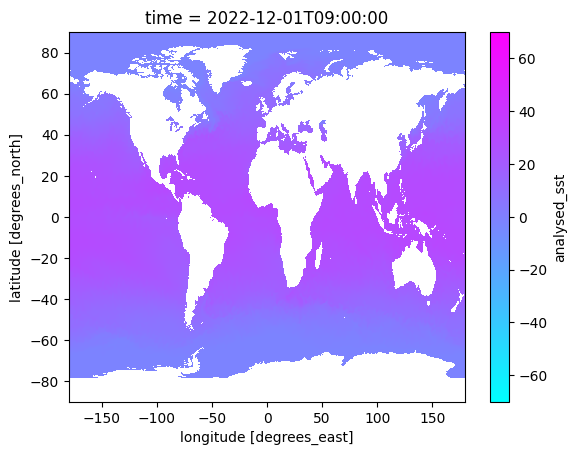

In [4]:
ds = xr.load_dataset('~/data/MUR25-JPL-L4-GLOB-v04.2/20221201090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc')

# select sst variable
sst = ds.analysed_sst

# convert to degrees Celcius
sst = sst - 273.15

# only select every 100th point
#sst = sst[0, ::20, ::20]
sst = sst[0,:,:]

db_items = {}

'''
for lat in sst.lat.values:
    for lon in sst.lon.values:
        
        db_entry = {
            "time": sst.time.values,
            "lat": lat,
            "lon": lon,
            "sst": sst.loc[dict(lat=lat, lon=lon)].values
        }

        db_items[sst.time.values] = db_entry
'''
# plot the data
p = sst.plot(subplot_kws=dict(transform=ccrs.PlateCarree()), vmin=-70, vmax=70, cmap=plt.cm.cool)


## Convert to Parquet file

In [123]:
ds = xr.load_dataset('~/data/MUR25-JPL-L4-GLOB-v04.2/20221201090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc')
#ds= xr.load_dataset('~/data/MUR25-JPL-L4-GLOB-v04.2/20221210090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc')
#ds= xr.load_dataset('~/data/MUR25-JPL-L4-GLOB-v04.2/20221220090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc')

# -----------------------
# unpack data from netcdf
# -----------------------
time = str(ds.time.values[0])

lats = ds.lat.values
lons = ds.lon.values

sst = ds['analysed_sst'][0,:,:].values
sst_anom = ds['sst_anomaly'][0,:,:].values

# -----------------------
# convert data to columns
# -----------------------

data_sst = sst.reshape(-1)
data_sst_anom = sst_anom.reshape(-1)

Y, X = np.unravel_index(range(sst.size), sst.shape)

num_points = len(data_sst)
point_id_list = [i for i in range(num_points)]

time_list = [time for _ in range(num_points)]

lat_value_list = [lats[idx] for idx in Y]
lon_value_list = [lons[idx] for idx in X]

# ---------------------------------
# create pandas dataframe structure 
# ---------------------------------

COLUMNS = ["time", "point_id", "Y", "X", "lats", "lons", "analysed_sst", "sst_anomaly"]

sst_df = pd.DataFrame(columns=COLUMNS)

tuple_list = list(zip(time_list, point_id_list, Y, X, lat_value_list, lon_value_list, data_sst, data_sst_anom))


# Add data to the output dataframe
new_data = pd.DataFrame(tuple_list, columns=COLUMNS)

sst_df = pd.concat([sst_df, new_data])

#sst_df = sst.to_pandas()

#sst_df.columns = sst_df.columns.astype(str)

sst_pq = sst_df.to_parquet("~/data/" + time + ".parquet")

In [7]:
sst_df

time point_id    Y     X    lats     lons  \
0        2022-12-01T09:00:00.000000000        0    0     0 -89.875 -179.875   
1        2022-12-01T09:00:00.000000000        1    0     1 -89.875 -179.625   
2        2022-12-01T09:00:00.000000000        2    0     2 -89.875 -179.375   
3        2022-12-01T09:00:00.000000000        3    0     3 -89.875 -179.125   
4        2022-12-01T09:00:00.000000000        4    0     4 -89.875 -178.875   
...                                ...      ...  ...   ...     ...      ...   
1036795  2022-12-01T09:00:00.000000000  1036795  719  1435  89.875  178.875   
1036796  2022-12-01T09:00:00.000000000  1036796  719  1436  89.875  179.125   
1036797  2022-12-01T09:00:00.000000000  1036797  719  1437  89.875  179.375   
1036798  2022-12-01T09:00:00.000000000  1036798  719  1438  89.875  179.625   
1036799  2022-12-01T09:00:00.000000000  1036799  719  1439  89.875  179.875   

         analysed_sst  sst_anomaly  
0                 NaN          NaN  
1                 NaN          NaN  
2                 NaN          NaN  
3                 NaN          NaN  
4                 NaN          NaN  
...               ...          ...  
1036795    271.350006          0.0  
1036796    271.350006          0.0  
1036797    271.350006          0.0  
1036798    271.350006          0.0  
1036799    271.350006          0.0  

[1036800 rows x 8 columns]

In [135]:
import json

#print(range(sst_df.shape[0]))

BATCH_SIZE = 100
for i in range(sst_df.shape[0]):
    #print(i)
    if i==0:
        continue
    else:
        #print('Chunk: ')
        chunk = sst_df[i:i+BATCH_SIZE]
        #print(chunk)

        #chunk_str = json.dumps(chunk.to_string(index=False))
        #chunk_str = chunk.to_string(index=False)
        chunk_str = chunk.to_json()
        #print('\n it is a string: ')
        #print(chunk_str)
        
        #chunk_df = pd.read_csv(StringIO(json.loads(chunk_str)))
        chunk_df = pd.read_json(chunk_str, orient='records')
        #row_df = pd.DataFrame(row)
        #chunk_df = pd.DataFrame.from_dict(chunk_str)
        #print('\n back to DF: ')
        #print(chunk_df[1:5])

        rows_df = pd.DataFrame.from_dict(chunk)
        #print(rows_df)
        
        for i, row in rows_df.iterrows():
            print(row)

            pid = row['point_id']
            ptime = row['time']

            COLUMNS = ["time", "point_id", "Y", "X", "lats", "lons", "analysed_sst", "sst_anomaly"]



            # Add data to the output dataframe
            new_data = pd.DataFrame(row, columns=COLUMNS)


            df = row.to_frame().T

            print(df)

            df.to_parquet('geo_points/' + str(pid) + '/' + str(ptime) + '.parquet')

            break
            
        
    break


time            2022-12-01T09:00:00.000000000
point_id                                    1
Y                                           0
X                                           1
lats                                  -89.875
lons                                 -179.625
analysed_sst                              NaN
sst_anomaly                               NaN
Name: 1, dtype: object
                            time point_id  Y  X    lats     lons analysed_sst  \
1  2022-12-01T09:00:00.000000000        1  0  1 -89.875 -179.625          NaN   

  sst_anomaly  
1         NaN  


OSError: Cannot save file into a non-existent directory: 'geo_points/1'

In [122]:
for col_name, data in sst_df.items():
    print("First valid index for column {} is at {}".format(col_name, data.first_valid_index()))

First valid index for column time is at 0
First valid index for column point_id is at 0
First valid index for column Y is at 0
First valid index for column X is at 0
First valid index for column lats is at 0
First valid index for column lons is at 0
First valid index for column analysed_sst is at 66240
First valid index for column sst_anomaly is at 66240


In [100]:
sst_df

time point_id    Y     X    lats     lons  \
0        2022-12-20T09:00:00.000000000        0    0     0 -89.875 -179.875   
1        2022-12-20T09:00:00.000000000        1    0     1 -89.875 -179.625   
2        2022-12-20T09:00:00.000000000        2    0     2 -89.875 -179.375   
3        2022-12-20T09:00:00.000000000        3    0     3 -89.875 -179.125   
4        2022-12-20T09:00:00.000000000        4    0     4 -89.875 -178.875   
...                                ...      ...  ...   ...     ...      ...   
1036795  2022-12-20T09:00:00.000000000  1036795  719  1435  89.875  178.875   
1036796  2022-12-20T09:00:00.000000000  1036796  719  1436  89.875  179.125   
1036797  2022-12-20T09:00:00.000000000  1036797  719  1437  89.875  179.375   
1036798  2022-12-20T09:00:00.000000000  1036798  719  1438  89.875  179.625   
1036799  2022-12-20T09:00:00.000000000  1036799  719  1439  89.875  179.875   

         analysed_sst  sst_anomaly  
0                 NaN          NaN  
1                 NaN          NaN  
2                 NaN          NaN  
3                 NaN          NaN  
4                 NaN          NaN  
...               ...          ...  
1036795    271.350006          0.0  
1036796    271.350006          0.0  
1036797    271.350006          0.0  
1036798    271.350006          0.0  
1036799    271.350006          0.0  

[1036800 rows x 8 columns]

In [131]:

for i in range(sst_df.shape[0]):
    row = sst_df[i:i+1]
    #print(row)

    pid = row['point_id'][i]
    ptime = row['time'][i]
    print(str(pid))
    print(str(ptime))
    
    dir = "/Users/vmcdonal/data/sst/mur25/" + str(pid) + "/"

    if not os.path.exists(dir):
        os.makedirs(dir)
    
    row.to_parquet(dir + str(ptime) + ".parquet")


0
2022-12-01T09:00:00.000000000
1
2022-12-01T09:00:00.000000000
2
2022-12-01T09:00:00.000000000
3
2022-12-01T09:00:00.000000000
4
2022-12-01T09:00:00.000000000
5
2022-12-01T09:00:00.000000000
6
2022-12-01T09:00:00.000000000
7
2022-12-01T09:00:00.000000000
8
2022-12-01T09:00:00.000000000
9
2022-12-01T09:00:00.000000000
10
2022-12-01T09:00:00.000000000
11
2022-12-01T09:00:00.000000000
12
2022-12-01T09:00:00.000000000
13
2022-12-01T09:00:00.000000000
14
2022-12-01T09:00:00.000000000
15
2022-12-01T09:00:00.000000000
16
2022-12-01T09:00:00.000000000
17
2022-12-01T09:00:00.000000000
18
2022-12-01T09:00:00.000000000
19
2022-12-01T09:00:00.000000000
20
2022-12-01T09:00:00.000000000
21
2022-12-01T09:00:00.000000000
22
2022-12-01T09:00:00.000000000
23
2022-12-01T09:00:00.000000000
24
2022-12-01T09:00:00.000000000
25
2022-12-01T09:00:00.000000000
26
2022-12-01T09:00:00.000000000
27
2022-12-01T09:00:00.000000000
28
2022-12-01T09:00:00.000000000
29
2022-12-01T09:00:00.000000000
30
2022-12-01T09:00:

KeyboardInterrupt: 

In [102]:
df = pd.read_parquet("~/data/sst/mur25/" + str(ptime) + ".parquet")

In [2]:
df = pd.read_parquet("~/data/" + time + ".parquet")

NameError: name 'time' is not defined

In [263]:
df = pd.read_parquet("~/data/sst/mur25/68280/")

In [264]:
df

time  point_id   Y    X    lats    lons  \
68280  2022-12-01T09:00:00.000000000     68280  47  600 -78.125 -29.875   
68280  2022-12-10T09:00:00.000000000     68280  47  600 -78.125 -29.875   
68280  2022-12-20T09:00:00.000000000     68280  47  600 -78.125 -29.875   

       analysed_sst  sst_anomaly  
68280           NaN          NaN  
68280           NaN          NaN  
68280           NaN          NaN

In [265]:
results = df.iloc[0, 1:6]

col_list_to_calc = ['analysed_sst']
#sum = df[col_list_to_calc].sum()
#mean = df[col_list_to_calc].mean()

results['sum'] = df[col_list_to_calc].sum().values[0]
results['mean'] = df[col_list_to_calc].mean().values[0]
results['variance'] = df[col_list_to_calc].var().values[0]
results['standard_dev'] = df[col_list_to_calc].std().values[0]

In [266]:
results

point_id         68280
Y                   47
X                  600
lats           -78.125
lons           -29.875
sum                0.0
mean               NaN
variance           NaN
standard_dev       NaN
Name: 68280, dtype: object

In [267]:
results['point_id']

68280

In [268]:
COLUMNS = ["point_id", "Y", "X", "lats", "lons", "sum", "mean", "variance", "standard_dev"]

tuple_list = [[
    results['point_id'], 
    results['Y'], results['X'], results['lats'], results['lons'], 
    results['sum'], results['mean'], results['variance'], results['standard_dev']]]

# Add data to the output dataframe
output = pd.DataFrame(tuple_list, columns=COLUMNS)

output

point_id   Y    X    lats    lons  sum  mean  variance  standard_dev
0     68280  47  600 -78.125 -29.875  0.0   NaN       NaN           NaN

In [269]:
dir = "/Users/vmcdonal/data/sst/mur25/result_stats/"

if not os.path.exists(dir):
        os.makedirs(dir)
        
output.to_parquet(dir + str(results['point_id']) + "_result_statistics.parquet")

In [206]:
for r in results:
    print(r)

66260
46
20
-78.375
-174.875
814.2369995117188
271.4123229980469
0.00972045212984085
0.0985923558473587


In [270]:
print(dir)
rp = pd.read_parquet(dir)
rp

/Users/vmcdonal/data/sst/mur25/result_stats/


point_id   Y    X    lats     lons         sum        mean  variance  \
0     66240  46    0 -78.375 -179.875  814.433960  271.477997  0.030514   
1     66260  46   20 -78.375 -174.875  814.237000  271.412323  0.009720   
2     66280  46   40 -78.375 -169.875  814.158997  271.386322  0.003959   
3     68280  47  600 -78.125  -29.875    0.000000         NaN       NaN   
4     75280  52  400 -76.875  -79.875    0.000000         NaN       NaN   

   standard_dev  
0      0.174682  
1      0.098592  
2      0.062919  
3           NaN  
4           NaN

In [271]:
grid_pairs = [(x,y) for x in pd.unique(rp['lats']) for y in pd.unique(rp['lons'])]

tmp_grid = np.array(grid_pairs)
full_grid = pd.DataFrame({'lats': tmp_grid[:,0], 'lons': tmp_grid[:,1]})
full_grid = full_grid.sort_values(by=['lats','lons'])
full_grid = full_grid.reset_index(drop=True)


full_grid

lats     lons
0  -78.375 -179.875
1  -78.375 -174.875
2  -78.375 -169.875
3  -78.375  -79.875
4  -78.375  -29.875
5  -78.125 -179.875
6  -78.125 -174.875
7  -78.125 -169.875
8  -78.125  -79.875
9  -78.125  -29.875
10 -76.875 -179.875
11 -76.875 -174.875
12 -76.875 -169.875
13 -76.875  -79.875
14 -76.875  -29.875

In [272]:
data_onto_full_grid = pd.merge(full_grid, rp, how='left')

data_onto_full_grid

lats     lons  point_id     Y      X         sum        mean  variance  \
0  -78.375 -179.875   66240.0  46.0    0.0  814.433960  271.477997  0.030514   
1  -78.375 -174.875   66260.0  46.0   20.0  814.237000  271.412323  0.009720   
2  -78.375 -169.875   66280.0  46.0   40.0  814.158997  271.386322  0.003959   
3  -78.375  -79.875       NaN   NaN    NaN         NaN         NaN       NaN   
4  -78.375  -29.875       NaN   NaN    NaN         NaN         NaN       NaN   
5  -78.125 -179.875       NaN   NaN    NaN         NaN         NaN       NaN   
6  -78.125 -174.875       NaN   NaN    NaN         NaN         NaN       NaN   
7  -78.125 -169.875       NaN   NaN    NaN         NaN         NaN       NaN   
8  -78.125  -79.875       NaN   NaN    NaN         NaN         NaN       NaN   
9  -78.125  -29.875   68280.0  47.0  600.0    0.000000         NaN       NaN   
10 -76.875 -179.875       NaN   NaN    NaN         NaN         NaN       NaN   
11 -76.875 -174.875       NaN   NaN    NaN         NaN         NaN       NaN   
12 -76.875 -169.875       NaN   NaN    NaN         NaN         NaN       NaN   
13 -76.875  -79.875   75280.0  52.0  400.0    0.000000         NaN       NaN   
14 -76.875  -29.875       NaN   NaN    NaN         NaN         NaN       NaN   

    standard_dev  
0       0.174682  
1       0.098592  
2       0.062919  
3            NaN  
4            NaN  
5            NaN  
6            NaN  
7            NaN  
8            NaN  
9            NaN  
10           NaN  
11           NaN  
12           NaN  
13           NaN  
14           NaN

In [275]:
out_lat = pd.unique(data_onto_full_grid['lats'])
out_lon = pd.unique(data_onto_full_grid['lons'])

sum_2d = data_onto_full_grid['sum'].values.reshape(len(pd.unique(data_onto_full_grid['lats'])),len(pd.unique(data_onto_full_grid['lons'])))
sum_xr = xr.DataArray(sum_2d, coords=[('lat', out_lat),('lon', out_lon)])
sum_xr = sum_xr.rename("sum")

mean_2d = data_onto_full_grid['mean'].values.reshape(len(pd.unique(data_onto_full_grid['lats'])),len(pd.unique(data_onto_full_grid['lons'])))
mean_xr = xr.DataArray(mean_2d, coords=[('lat', out_lat),('lon', out_lon)])
mean_xr = mean_xr.rename("mean")

var_2d = data_onto_full_grid['variance'].values.reshape(len(pd.unique(data_onto_full_grid['lats'])),len(pd.unique(data_onto_full_grid['lons'])))
var_xr = xr.DataArray(var_2d, coords=[('lat', out_lat),('lon', out_lon)])
var_xr = var_xr.rename("var")

std_2d = data_onto_full_grid['standard_dev'].values.reshape(len(pd.unique(data_onto_full_grid['lats'])),len(pd.unique(data_onto_full_grid['lons'])))
std_xr = xr.DataArray(std_2d, coords=[('lat', out_lat),('lon', out_lon)])
std_xr = sum_xr.rename("std")

ds = xr.Dataset(

    data_vars={"sum": sum_xr,
               "mean": mean_xr,
               "variance": var_xr,
               "standard_dev": std_xr}
)

ds


<xarray.Dataset>
Dimensions:       (lat: 3, lon: 5)
Coordinates:
  * lat           (lat) float32 -78.38 -78.12 -76.88
  * lon           (lon) float32 -179.9 -174.9 -169.9 -79.88 -29.88
Data variables:
    sum           (lat, lon) float64 814.4 814.2 814.2 nan ... nan nan 0.0 nan
    mean          (lat, lon) float64 271.5 271.4 271.4 nan ... nan nan nan nan
    variance      (lat, lon) float64 0.03051 0.00972 0.003959 ... nan nan nan
    standard_dev  (lat, lon) float64 814.4 814.2 814.2 nan ... nan nan 0.0 nan

In [276]:
ds.to_netcdf('~/data/sst/mur25/full_stats.nc')

In [187]:
ds = xr.load_dataset('~/data/sst/mur25/full_stats.nc')
ds

<xarray.Dataset>
Dimensions:       (lats: 1, lons: 2)
Coordinates:
  * lats          (lats) float64 -78.38
  * lons          (lons) float64 -179.9 -174.9
Data variables:
    point_id      (lats, lons) int64 66240 66260
    Y             (lats, lons) int64 46 46
    X             (lats, lons) int64 0 20
    sum           (lats, lons) float64 814.4 814.2
    mean          (lats, lons) float64 271.5 271.4
    variance      (lats, lons) float64 0.03051 0.00972
    standard_dev  (lats, lons) float64 0.1747 0.09859

In [188]:
ds.plot(sum)

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

### Analyze second granule - December 10

In [92]:
ds2= xr.load_dataset('~/data/MUR25-JPL-L4-GLOB-v04.2/20221210090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc')

# select sst variable
sst2 = ds2.analysed_sst

# convert to degrees Celcius
#sst2 = sst2 - 273.15

# only select every 100th point
#sst2 = sst2[0, ::20, ::20]
sst2 = sst2[0, :, :]


# plot the data
p2 = sst2.plot(subplot_kws=dict(transform=ccrs.PlateCarree()), vmin=-70, vmax=70, cmap=plt.cm.cool)


convert to parquet

In [23]:
# -----------------------
# unpack data from netcdf
# -----------------------
time = str(ds2.time.values[0])

lats = ds2.lat.values
lons = ds2.lon.values

sst = ds2['analysed_sst'][0,:,:].values
sst_anom = ds2['sst_anomaly'][0,:,:].values


# -----------------------
# convert data to columns
# -----------------------

data_sst = sst.reshape(-1,1)
data_sst_anom = sst_anom.reshape(-1,1)

Y, X = np.unravel_index(range(sst.size), sst.shape)

num_points = len(data_sst)
point_id_list = [i for i in range(num_points)]

time_list = [time for _ in range(num_points)]

lat_value_list = [lats[idx] for idx in Y]
lon_value_list = [lons[idx] for idx in X]

# ---------------------------------
# create pandas dataframe structure 
# ---------------------------------

COLUMNS = ["time", "point_id", "Y", "X", "lats", "lons", "analysed_sst", "sst_anomaly"]

sst_df = pd.DataFrame(columns=COLUMNS)

tuple_list = list(zip(time_list, point_id_list, Y, X, lat_value_list, lon_value_list, data_sst, data_sst_anom))

# Add data to the output dataframe
new_data = pd.DataFrame(tuple_list, columns=COLUMNS)

sst_df = pd.concat([sst_df, new_data])

#sst_df = sst.to_pandas()

#sst_df.columns = sst_df.columns.astype(str)

sst_pq = sst_df.to_parquet("~/data/" + time + ".parquet")

### Analyze 3rd granule - Dec 20

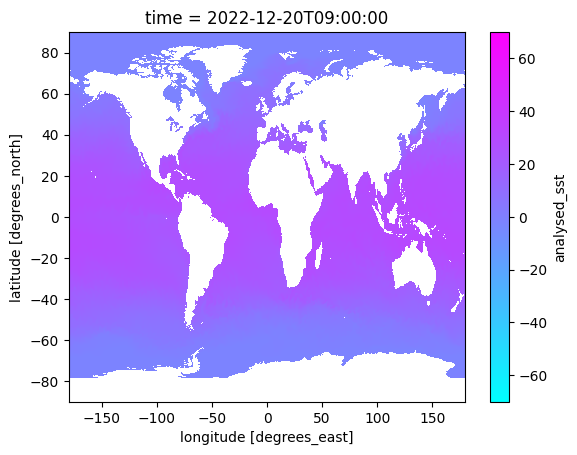

In [37]:
ds3= xr.load_dataset('~/data/MUR25-JPL-L4-GLOB-v04.2/20221220090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc')

# select sst variable
sst3 = ds3.analysed_sst

# convert to degrees Celcius
sst3 = sst3 - 273.15

# only select every 100th point
#sst3 = sst3[0, ::20, ::20]
sst3 = sst3[0, :, :]


# plot the data
p3 = sst3.plot(subplot_kws=dict(transform=ccrs.PlateCarree()), vmin=-70, vmax=70, cmap=plt.cm.cool)

In [35]:
# -----------------------
# unpack data from netcdf
# -----------------------
time = str(ds3.time.values[0])

lats = ds3.lat.values
lons = ds3.lon.values

sst = ds3['analysed_sst'][0,:,:].values
sst_anom = ds3['sst_anomaly'][0,:,:].values


# -----------------------
# convert data to columns
# -----------------------

data_sst = sst.reshape(-1,1)
data_sst_anom = sst_anom.reshape(-1,1)

Y, X = np.unravel_index(range(sst.size), sst.shape)

num_points = len(data_sst)
point_id_list = [i for i in range(num_points)]

time_list = [time for _ in range(num_points)]

lat_value_list = [lats[idx] for idx in Y]
lon_value_list = [lons[idx] for idx in X]

# ---------------------------------
# create pandas dataframe structure 
# ---------------------------------

COLUMNS = ["time", "point_id", "Y", "X", "lats", "lons", "analysed_sst", "sst_anomaly"]

sst_df = pd.DataFrame(columns=COLUMNS)

tuple_list = list(zip(time_list, point_id_list, Y, X, lat_value_list, lon_value_list, data_sst, data_sst_anom))

# Add data to the output dataframe
new_data = pd.DataFrame(tuple_list, columns=COLUMNS)

sst_df = pd.concat([sst_df, new_data])

#sst_df = sst.to_pandas()

#sst_df.columns = sst_df.columns.astype(str)

sst_pq = sst_df.to_parquet("~/data/" + time + ".parquet")

### Calculate Statistics

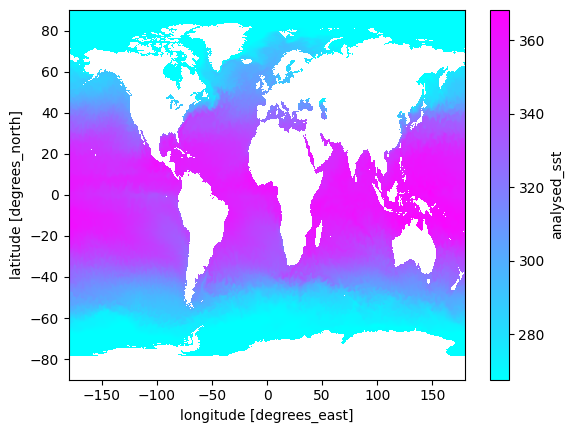

In [43]:
pixel_sum = sst + sst2 + sst3

plot_sum = pixel_sum.plot(subplot_kws=dict(transform=ccrs.PlateCarree()), cmap=plt.cm.cool)

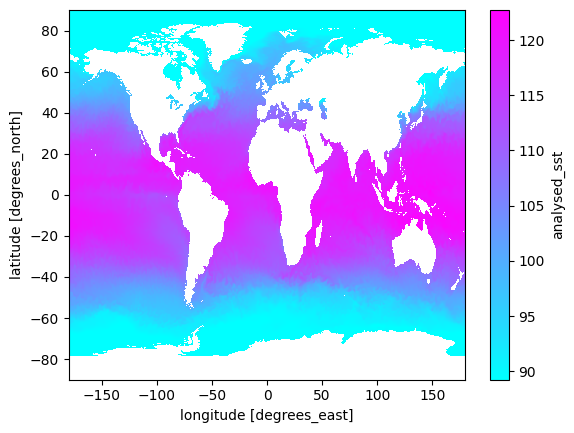

In [39]:
pixel_mean = (sst + sst2 + sst3)/3

pixel_mean.plot(subplot_kws=dict(transform=ccrs.PlateCarree()), cmap=plt.cm.cool)

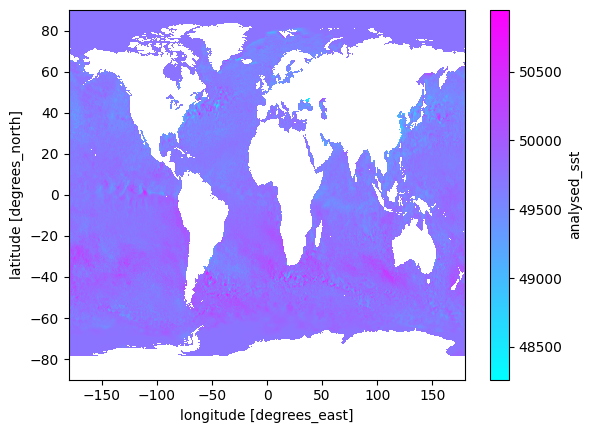

In [40]:
# sum of squares
pixel_sum_squares = (sst-pixel_mean)**2 + (sst2-pixel_mean)**2 + (sst3-pixel_mean)**2

plot_sum_sq = pixel_sum_squares.plot(subplot_kws=dict(transform=ccrs.PlateCarree()), cmap=plt.cm.cool)

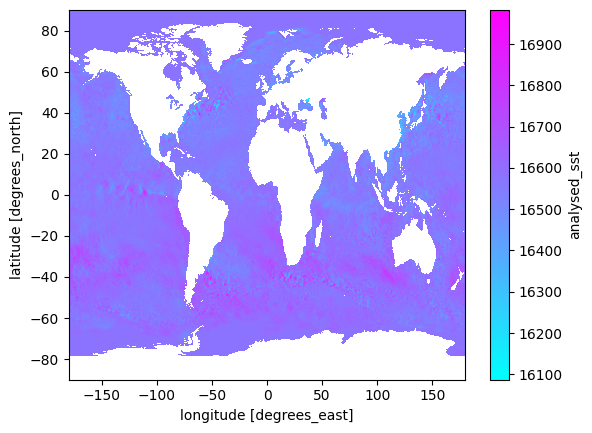

In [41]:
# Variance
pixel_variance = pixel_sum_squares/3

plot_variance = pixel_variance.plot(subplot_kws=dict(transform=ccrs.PlateCarree()), cmap=plt.cm.cool)

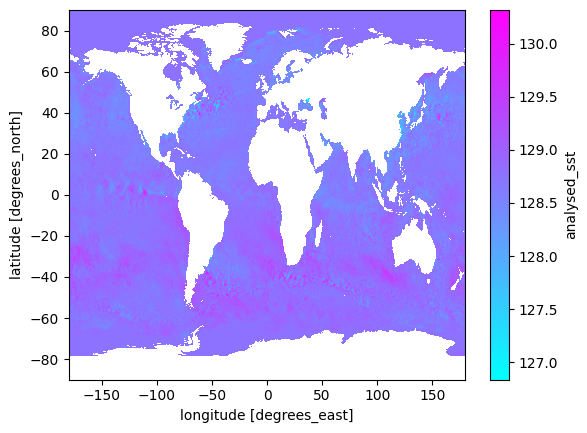

In [42]:
# standard deviation
pixel_sd = np.sqrt(pixel_variance)

plot_sd = pixel_sd.plot(subplot_kws=dict(transform=ccrs.PlateCarree()), cmap=plt.cm.cool)